# XGBoost Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
yf.pdr_override()


In [2]:
# input
symbol = 'AMD'
start = '2014-01-01'
end = '2018-08-27'

# Read data 
dataset = yf.download(symbol,start,end)

# View Columns
dataset.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,3.85,3.98,3.84,3.95,3.95,20548400
2014-01-03,3.98,4.00,3.88,4.00,4.00,22887200
2014-01-06,4.01,4.18,3.99,4.13,4.13,42398300
2014-01-07,4.19,4.25,4.11,4.18,4.18,42932100
2014-01-08,4.23,4.26,4.14,4.18,4.18,30678700


In [3]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-20,19.790001,20.08,19.350000,19.980000,19.980000,62983200
2018-08-21,19.980000,20.42,19.860001,20.400000,20.400000,55629000
2018-08-22,20.280001,20.92,20.209999,20.900000,20.900000,62002700
2018-08-23,21.190001,22.32,21.139999,22.290001,22.290001,113444100
2018-08-24,22.910000,24.00,22.670000,23.980000,23.980000,164328200


In [4]:
dataset['Increase_Decrease'] = np.where(dataset['Volume'].shift(-1) > dataset['Volume'],1,0)
dataset['Buy_Sell_on_Open'] = np.where(dataset['Open'].shift(-1) > dataset['Open'],1,0)
dataset['Buy_Sell'] = np.where(dataset['Adj Close'].shift(-1) > dataset['Adj Close'],1,0)
dataset['Returns'] = dataset['Adj Close'].pct_change()
dataset = dataset.dropna()

In [5]:
dataset.shape

(1170, 10)

In [6]:
X = dataset[['Open', 'High', 'Low', 'Volume', 'Increase_Decrease', 'Buy_Sell_on_Open', 'Buy_Sell', 'Returns']].values
y = dataset['Adj Close'].values

In [7]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth":    [4, 5],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

In [9]:
model = xgb.XGBRegressor(eval_metric='rmsle')

In [10]:
search = GridSearchCV(model, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 700}


In [11]:
model = xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmsle',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.015, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=700, n_jobs=20,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [12]:
y_pred = model.predict(X_test)

In [13]:
from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_test, y_pred))
print("The score is %.5f" % RMSLE )

The score is 0.01417


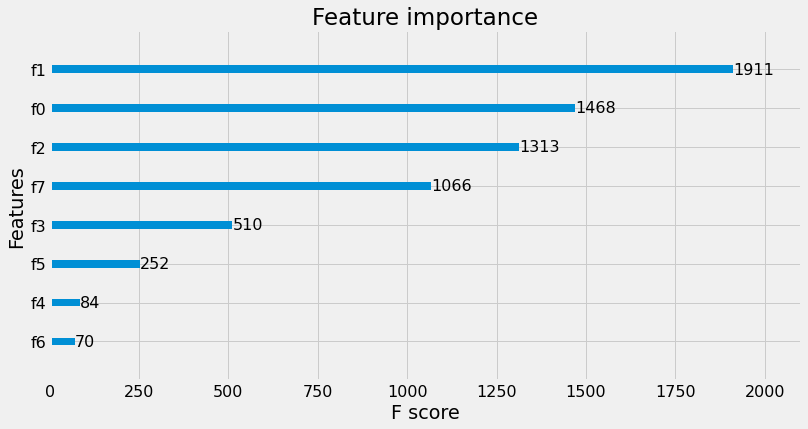

In [14]:
from xgboost import plot_importance

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(model, max_num_features=8, ax=ax)
plt.show()

In [16]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.09061099034527463
MSE: 0.04297599802450726
RMSE: 0.20730653155293313
